In [1]:
%matplotlib inline
import numpy as np
import gp_grid
import matplotlib.pyplot as plt
from gp_grid.misc import rastrigin, grid2mat, gapify_data

We will consider a two-dimensional synthetic dataset (the Rastrigin function) for visualization and randomly remove 65% of the data for training.

In [2]:
np.random.seed(0)
d = 2

# generate the training set
n = 50 # number of points along each dimension
N_missing = np.int32(np.floor(0.65*n**d))
xg = [np.linspace(0,1,num=n).reshape((-1,1)),]*d
x = grid2mat(*xg)
y = rastrigin((x*2-1)*5.12)
gaps = np.random.choice(y.shape[0], size=N_missing, replace=False) # randomly set some data to nan
y[gaps] = np.nan
yg = y.reshape((n,)*d)

# generate the test set
nn = 100 # number of test points along each dimension
xxg = [np.linspace(0,1,num=nn).reshape((-1,1)),]*d
xx = grid2mat(*xxg) 
yy = rastrigin((xx*2-1)*5.12)

We can now fit a model to this data set and plot the whole image (also at a higher resolution).
Because the data lies on a grid, GP inference can be performed extremely efficiently even though there are gaps in the dataset.

[ 01:09:25 ] gp_grid.models INFO: Function Evals: 11. Log-Marginal Likelihood: -39.4443.


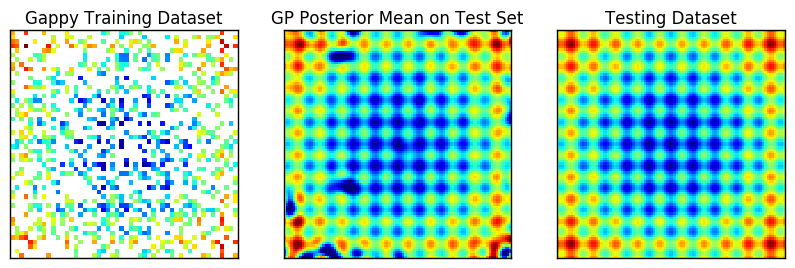

In [3]:
# initialize the kernel and the GP model
kern_list = [gp_grid.kern.RBF(1, lengthscale=0.05, variance=30.) for i in range(d)]
m = gp_grid.models.GPGappyRegression(xg,yg,kern_list,noise_var=1e-6)
m.optimize() # estimate the hyperparameters through log-marginal likelihood maximization

# plot the training data, the model prediction, and the testing data
fig, ax = plt.subplots(ncols=3, figsize=(10,4)) 
yyh = m.predict_grid(xxg) # the model prediction
ax[0].imshow(yg,interpolation='none',vmin=yy.min(), vmax=yy.max())
ax[0].set_title('Gappy Training Dataset')
ax[1].imshow(yyh.reshape((nn,)*d),interpolation='none',vmin=yy.min(), vmax=yy.max())
ax[1].set_title("GP Posterior Mean on Test Set")
ax[2].imshow(yy.reshape((nn,)*d),interpolation='none',vmin=yy.min(), vmax=yy.max())
ax[2].set_title('Testing Dataset')
for i in range(len(ax)): # remove ticks from figures to make pretty
    ax[i].tick_params(which='both', bottom=False, top=False, left=False, right=False, 
                       labelbottom=False,labelleft=False)